# Data Cleaning and Linear Regression Hierarchical Predicting 

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [183]:
# import data file downloaded from Crunchbase database
crunchbasedf = pd.read_csv('crunchbase_export.csv')

# import list of companies that we did sentiment analysis on
companies_list = pd.read_csv('companies.csv').company.tolist()

# make all company names lowercase for easier comparison
companies_list = [x.lower() for x in companies_list]
lowercase = lambda x: str(x).lower()
crunchbasedf.name = crunchbasedf.name.apply(lowercase)

In [160]:
# create formatter that changes string into proper format 
# (for some reason, the data in crunchbasedf is formatted 
# really weirdly, requiring me to do this)

def formatter(string):
    space = False
    formatted = ""
    for s in string:
        if space and (s is not ' '):
            formatted += s
        elif s == ' ':
            space = True
    return formatted

In [181]:
# ************************************************ #
# CREATE DATAFRAME WITH ONLY THE COMPANIES WE NEED #
# ************************************************ #

# declare lists of relevant demographics data we will be using
first_funding_date = []
last_funding_date = []
funding_total = []
founded_date = []
public = []
funding_rounds = []
new_companies_list = []

# iterate through list of companies to extract information for each companies
for company in companies_list:
    # check if company is in crunchbasedf
    if company in crunchbasedf.name.tolist():
        # only include companies in crunchbasedf
        new_companies_list.append(company)
        
        # create public variable
        if formatter(crunchbasedf[crunchbasedf.name==company].status.to_string()).strip() == "ipo":
            public.append(1)
        else:
            public.append(0)

        # create funding rounds variable
        funding_rounds.append(int(formatter(crunchbasedf[crunchbasedf.name==company].funding_rounds.to_string()).strip()))

        # create total funds variable
        funding_total.append(int(formatter(crunchbasedf[crunchbasedf.name==company][' funding_total_usd '].to_string()).replace(",","").strip()))

        # create last funding date variable
        last_funding_date.append(crunchbasedf[crunchbasedf.name==company].last_funding_at.to_string()[-10:])

        # create first funding date variable
        first_funding_date.append(crunchbasedf[crunchbasedf.name==company].first_funding_at.to_string()[-10:])

        # create founded date variable
        founded_date.append(crunchbasedf[crunchbasedf.name==company].founded_at.to_string()[-10:])

# create dictionary with all 
dfdict = {'company':new_companies_list,'first_funding_date':first_funding_date,'last_funding_date':last_funding_date,
          'funding_total':funding_total,'founded_date':founded_date,'public':public,'funding_rounds':funding_rounds}

In [202]:
# convert dictionary 
infodf = pd.DataFrame.from_dict(dfdict)

# added founded date into Vivint through other source, since Cruchbase didn't have it
infodf.loc[33,'founded_date'] = '1997-06-01'

# change strings into date items to calculate company age and time since last funding
infodf.first_funding_date = infodf.first_funding_date.apply(pd.datetools.parse)
infodf.last_funding_date = infodf.last_funding_date.apply(pd.datetools.parse)
infodf.founded_date = infodf.founded_date.apply(pd.datetools.parse)

infodf

,company,first_funding_date,founded_date,funding_rounds,funding_total,last_funding_date,public
0,facebook,2004-09-01,2004-02-04,11,2425700000,2011-01-21,1
1,google,1998-08-01,1998-09-07,3,26100000,1999-06-07,1
2,apple,1977-05-15,1976-04-01,1,250000,1977-05-15,1
3,amazon,1995-07-01,1994-07-05,1,8000000,1995-07-01,1
4,uber,2009-08-01,2009-03-01,13,8207450000,2015-09-07,0
5,lyft,2009-06-01,2012-01-01,8,1012500000,2015-05-15,0
6,airbnb,2009-01-01,2008-08-01,8,2394820000,2015-11-20,0
7,fitbit,2008-10-10,2007-05-01,4,66000000,2013-08-13,1
8,jawbone,2006-12-15,1999-01-01,12,818799995,2015-04-30,0
9,coursera,2012-04-18,2012-01-01,6,146100000,2015-10-27,0


In [209]:
# calculate age and time since last funding
import datetime
today = datetime.datetime(2015, 12, 10)
infodf['age'] = (today - infodf['founded_date']).values / np.timedelta64(1, 'D')
infodf['time_from_last_funding'] = (today - infodf['last_funding_date']).values / np.timedelta64(1, 'D')
infodf.head()

,company,first_funding_date,founded_date,funding_rounds,funding_total,last_funding_date,public,age,time_from_last_funding
0,facebook,2004-09-01,2004-02-04,11,2425700000,2011-01-21,1,4327,1784
1,google,1998-08-01,1998-09-07,3,26100000,1999-06-07,1,6303,6030
2,apple,1977-05-15,1976-04-01,1,250000,1977-05-15,1,14497,14088
3,amazon,1995-07-01,1994-07-05,1,8000000,1995-07-01,1,7828,7467
4,uber,2009-08-01,2009-03-01,13,8207450000,2015-09-07,0,2475,94


In [217]:
# convert csv's with sentiment predictions into pandas dataframes
bin_pred = pd.read_csv('company_with_predictions.csv')
range_pred = pd.read_csv('company_with_prediction_range.csv')

# drop first column (index column)
bin_pred = bin_pred.drop(bin_pred.columns[[0]], axis=1)
range_pred = range_pred.drop(range_pred.columns[[0]], axis=1)

# change name of column from 'name' to 'company' to allow dataframe to merge with infodf in next step
bin_pred = bin_pred.rename(columns={'name': 'company'})
range_pred = range_pred.rename(columns={'name': 'company'})

# make company names lowercase to allow for successful merge with infodf
bin_pred.company = bin_pred.company.apply(lowercase)
range_pred.company = range_pred.company.apply(lowercase)
bin_pred

,weighted_predict,company,predict_binary
0,-0.176471,airbnb,0.117647
1,-0.246377,amazon,-0.144928
2,-1.156124,apple,-0.067295
3,1.000000,asana,1.000000
4,0.000000,buzzfeed,-2.000000
5,0.000000,coursera,0.000000
6,-0.500000,doordash,-0.250000
7,0.750000,dropbox,0.250000
8,0.081967,fitbit,0.131148
9,-0.612903,google,-0.058065


In [218]:
# merge sentiment data with demographics data
newdf1 = pd.merge(infodf,bin_pred,how='inner',on=['company'])
newdf2 = pd.merge(infodf,range_pred,how='inner',on=['company'])

In [248]:
# drop unnecessary columns
newdf1 = newdf1.drop(['company','first_funding_date','founded_date','last_funding_date',], 1)
newdf2 = newdf2.drop(['company','first_funding_date','founded_date','last_funding_date',], 1)

Let's do some EDA to see the distribution of our data

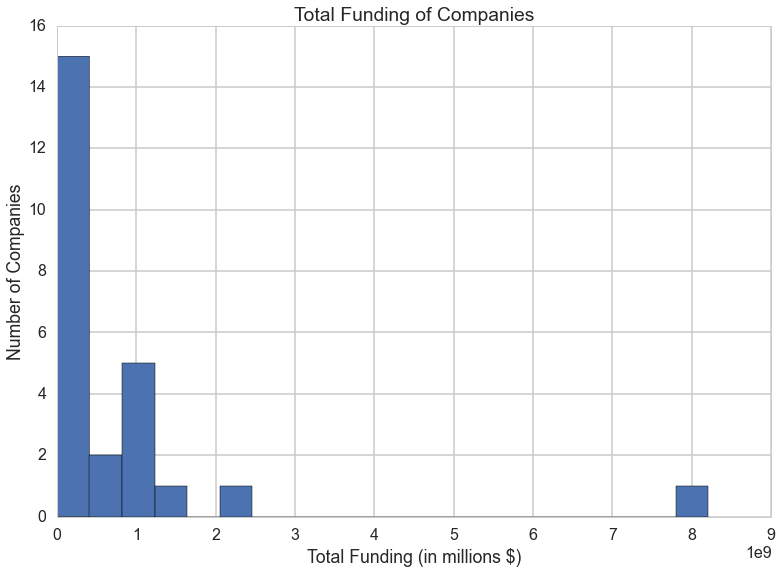

In [225]:
# histogram of total funding
plt.hist(newdf1.funding_total,bins=20)
plt.title("Total Funding of Companies")
plt.xlabel("Total Funding (in millions $)")
plt.ylabel("Number of Companies")

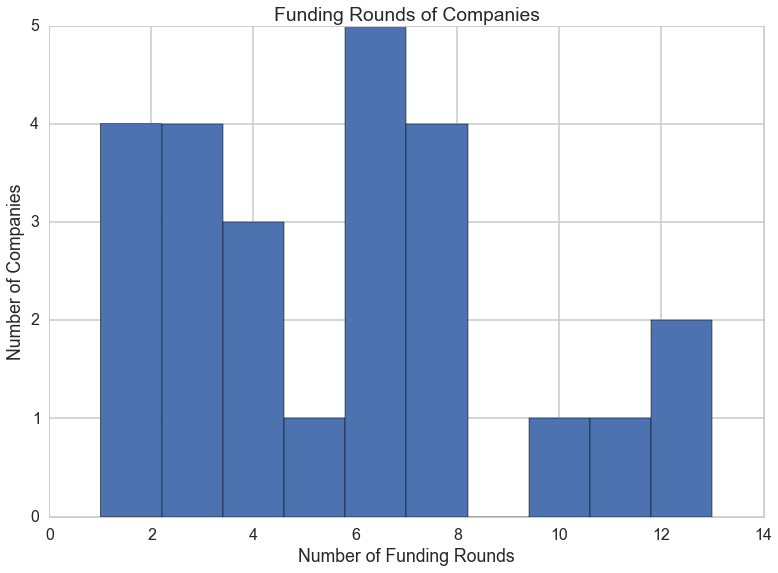

In [227]:
# histogram of number of funding rounds
plt.hist(newdf1.funding_rounds,bins=10)
plt.title("Funding Rounds of Companies")
plt.xlabel("Number of Funding Rounds")
plt.ylabel("Number of Companies")

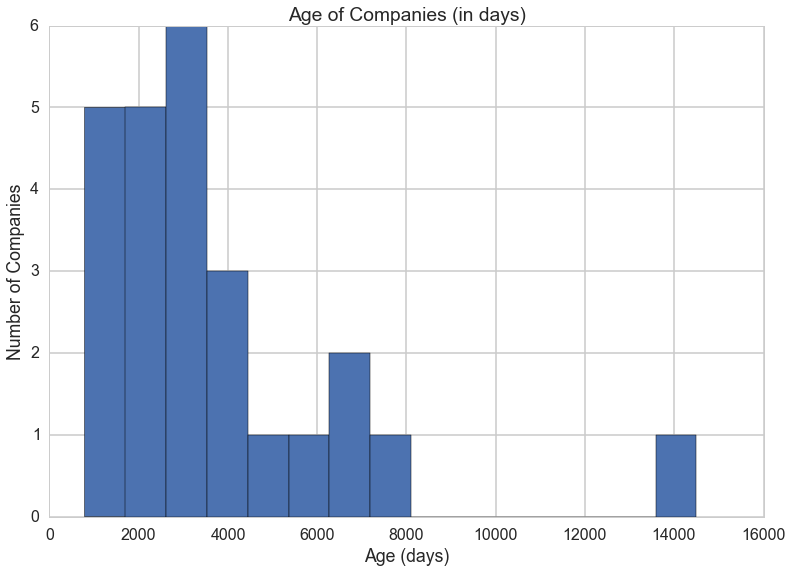

In [229]:
# histogram of age of companies
plt.hist(newdf1.age,bins=15)
plt.title("Age of Companies (in days)")
plt.xlabel("Age (days)")
plt.ylabel("Number of Companies")

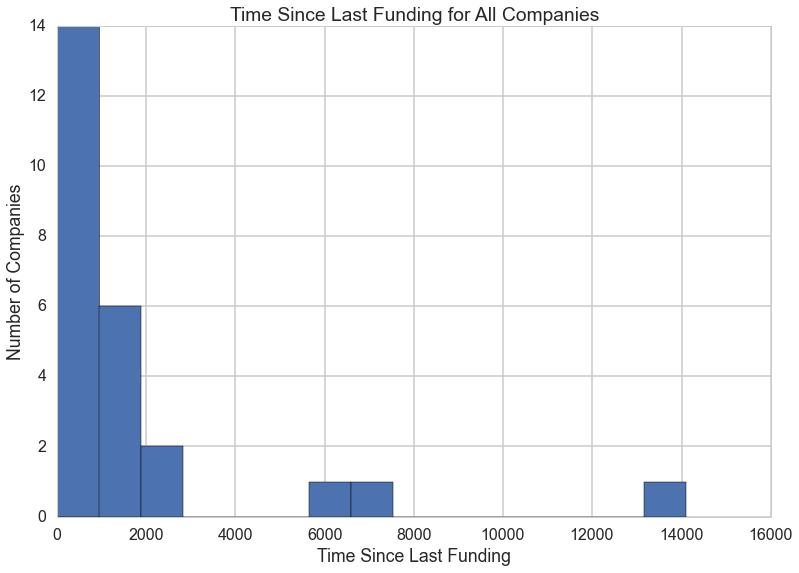

In [232]:
# histogram of time since last funding
plt.hist(newdf1.time_from_last_funding,bins=15)
plt.title("Time Since Last Funding for All Companies")
plt.xlabel("Time Since Last Funding")
plt.ylabel("Number of Companies")

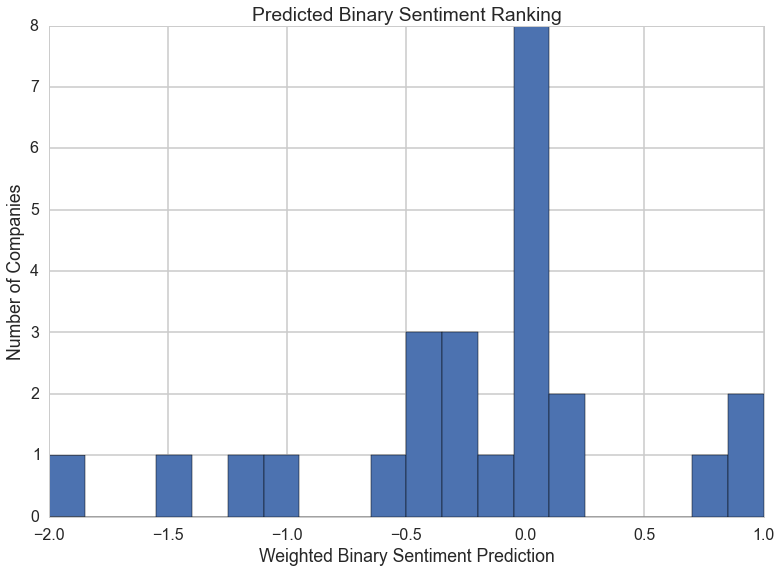

In [235]:
# histogram of weighted binary sentiment ranking
plt.hist(newdf1.weighted_predict,bins=20)
plt.title("Predicted Weighted Binary Sentiment Ranking")
plt.xlabel("Weighted Binary Sentiment Prediction")
plt.ylabel("Number of Companies")

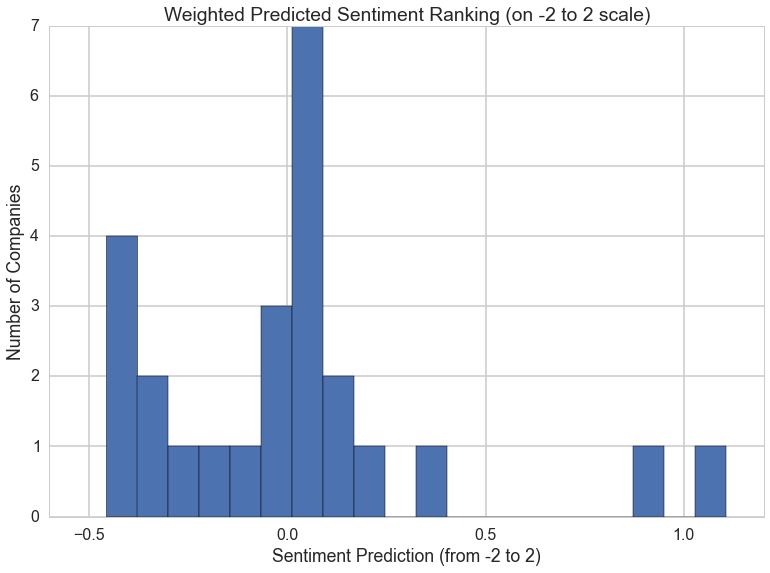

In [291]:
# histogram of weighted sentiment rank from -2 to 2
plt.hist(newdf2.weighted_predict_range,bins=20)
plt.title("Weighted Predicted Sentiment Ranking (on -2 to 2 scale)")
plt.xlabel("Sentiment Prediction (from -2 to 2)")
plt.ylabel("Number of Companies")

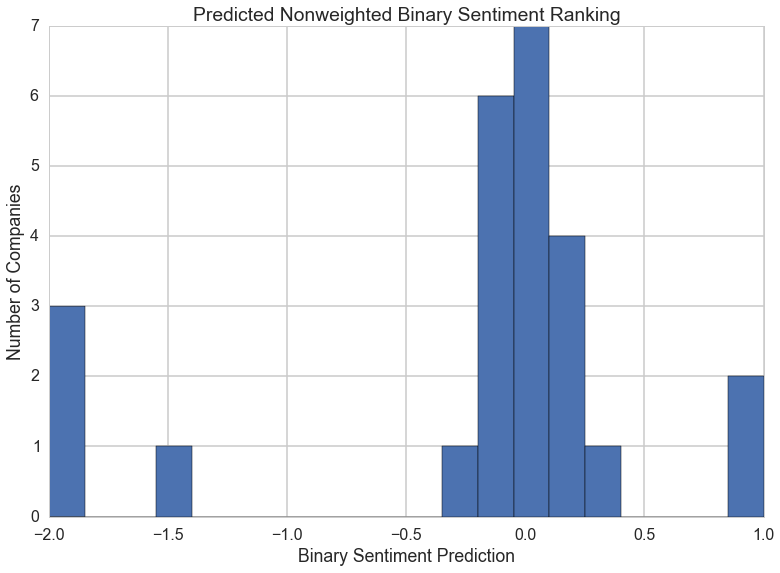

In [292]:
# histogram of binary sentiment ranking without weighting
plt.hist(newdf1.predict_binary,bins=20)
plt.title("Predicted Nonweighted Binary Sentiment Ranking")
plt.xlabel("Binary Sentiment Prediction")
plt.ylabel("Number of Companies")

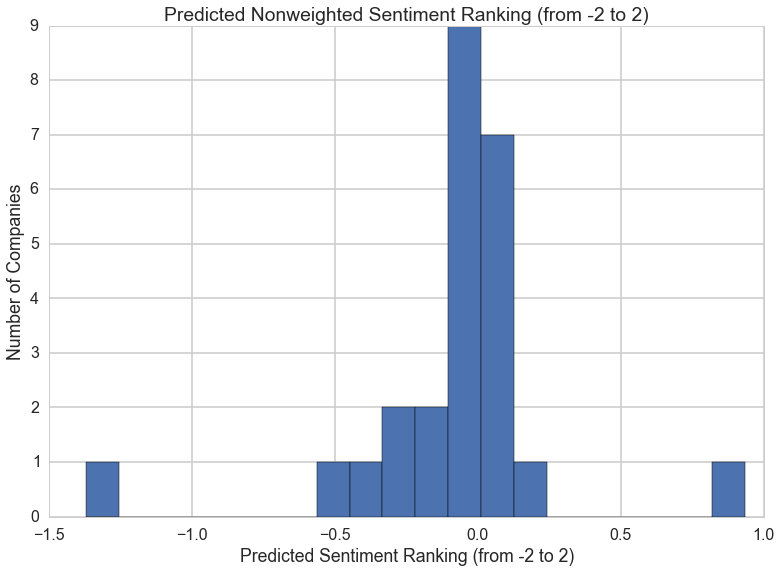

In [237]:
# histogram of sentiment ranking from -2 to 2 without weighting
plt.hist(newdf2.predict_range,bins=20)
plt.title("Predicted Nonweighted Sentiment Ranking (from -2 to 2)")
plt.xlabel("Predicted Sentiment Ranking (from -2 to 2)")
plt.ylabel("Number of Companies")

Let's try creating a linear regression model. First we try an ordinary least squares regression.

In [76]:
import statsmodels.api as sm
from statsmodels.formula.api import glm, ols

In [246]:
ols_model1 = ols('funding_total ~ time_from_last_funding + age + public + funding_rounds + weighted_predict + predict_binary', newdf1).fit()
ols_model2 = ols('funding_total ~ time_from_last_funding + age + public + funding_rounds + weighted_predict_range + predict_range', newdf2).fit()

In [247]:
ols_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          funding_total   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     2.924
Date:                Thu, 10 Dec 2015   Prob (F-statistic):             0.0359
Time:                        01:45:23   Log-Likelihood:                -557.16
No. Observations:                  25   AIC:                             1128.
Df Residuals:                      18   BIC:                             1137.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept              -1.276e+09   8.36e+08     -1.526      0.144     -3.03e+09  4.81e+08
time_from_last_funding  2.719e+05   2.73e+05      0.996      0.333     -3.02e+05  8.46e+05
age                    -8.986e+04   2.56e+05     -0.351      0.729     -6.27e+05  4.48e+05
public                 -6.239e+08   7.78e+08     -0.802      0.433     -2.26e+09  1.01e+09
funding_rounds           3.92e+08   1.09e+08      3.585      0.002      1.62e+08  6.22e+08
weighted_predict        5.688e+08   7.47e+08      0.762      0.456        -1e+09  2.14e+09
predict_binary          -2.89e+07   6.14e+08     -0.047      0.963     -1.32e+09  1.26e+09
==============================================================================
Omnibus:                       29.296   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.701
Skew:                           2.179   Prob(JB):                     3.28e-15
Kurtosis:                       9.711   Cond. No.                     2.16e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [251]:
ols_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          funding_total   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     2.628
Date:                Thu, 10 Dec 2015   Prob (F-statistic):             0.0522
Time:                        02:06:20   Log-Likelihood:                -557.80
No. Observations:                  25   AIC:                             1130.
Df Residuals:                      18   BIC:                             1138.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept              -1.077e+09   8.39e+08     -1.284      0.215     -2.84e+09  6.85e+08
time_from_last_funding   2.82e+05   2.59e+05      1.088      0.291     -2.62e+05  8.26e+05
age                    -1.678e+05   2.41e+05     -0.696      0.496     -6.74e+05  3.39e+05
public                   -7.1e+08   8.15e+08     -0.871      0.395     -2.42e+09     1e+09
funding_rounds          3.843e+08   1.09e+08      3.524      0.002      1.55e+08  6.13e+08
weighted_predict_range  6.496e+08   1.08e+09      0.602      0.554     -1.62e+09  2.92e+09
predict_range          -3.796e+08    1.1e+09     -0.346      0.734     -2.69e+09  1.93e+09
==============================================================================
Omnibus:                       30.275   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.542
Skew:                           2.288   Prob(JB):                     1.31e-15
Kurtosis:                       9.698   Cond. No.                     2.96e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Because our R^2 values are really poor, we will try using a forward stepwise regression. Code is from http://planspace.org/20150423-forward_selection_with_statsmodels/

In [252]:
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [253]:
ols_for_model1 = forward_selected(newdf1, 'funding_total')
ols_for_model2 = forward_selected(newdf2, 'funding_total')

In [254]:
ols_for_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          funding_total   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     8.556
Date:                Thu, 10 Dec 2015   Prob (F-statistic):            0.00178
Time:                        02:19:31   Log-Likelihood:                -558.47
No. Observations:                  25   AIC:                             1123.
Df Residuals:                      22   BIC:                             1127.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept      -8.911e+08   5.15e+08     -1.730      0.098     -1.96e+09  1.77e+08
funding_rounds  3.129e+08   7.77e+07      4.029      0.001      1.52e+08  4.74e+08
predict_binary  3.553e+08   3.31e+08      1.072      0.295     -3.32e+08  1.04e+09
==============================================================================
Omnibus:                       35.259   Durbin-Watson:                   1.722
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.670
Skew:                           2.582   Prob(JB):                     8.37e-23
Kurtosis:                      11.422   Cond. No.                         13.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [255]:
ols_for_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          funding_total   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     15.86
Date:                Thu, 10 Dec 2015   Prob (F-statistic):           0.000588
Time:                        02:19:58   Log-Likelihood:                -559.11
No. Observations:                  25   AIC:                             1122.
Df Residuals:                      23   BIC:                             1125.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept      -9.537e+08   5.13e+08     -1.858      0.076     -2.02e+09  1.08e+08
funding_rounds  3.101e+08   7.79e+07      3.982      0.001      1.49e+08  4.71e+08
==============================================================================
Omnibus:                       35.628   Durbin-Watson:                   1.743
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.732
Skew:                           2.576   Prob(JB):                     4.04e-24
Kurtosis:                      11.768   Cond. No.                         13.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This isn't a significant improvement, although the R^2 values are better. Because some of the data is extremely right skew and the linear regression is still doing a poor job, let's transform the skew data and try again.

In [259]:
# logging the skew data (based on the histograms from above)
newdf1['log_age'] = newdf1.age.apply(np.log)
newdf1['log_time_from_last_funding'] =  newdf1.time_from_last_funding.apply(np.log)
newdf2['log_age'] = newdf2.age.apply(np.log)
newdf2['log_time_from_last_funding'] =  newdf2.time_from_last_funding.apply(np.log)

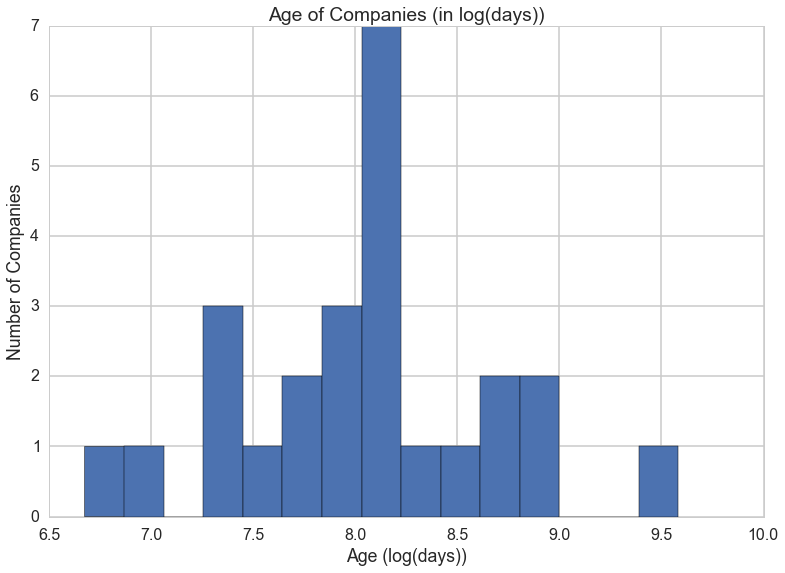

In [260]:
# histogram of log(age)
plt.hist(newdf1.log_age,bins=15)
plt.title("Age of Companies (in log(days))")
plt.xlabel("Age (log(days))")
plt.ylabel("Number of Companies")

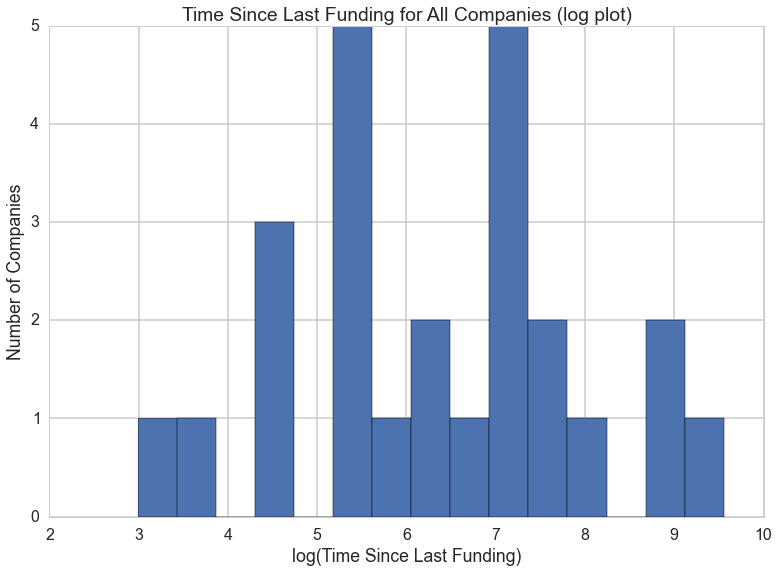

In [261]:
# histogram of log of time since last funding
plt.hist(newdf1.log_time_from_last_funding,bins=15)
plt.title("Time Since Last Funding for All Companies (log plot)")
plt.xlabel("log(Time Since Last Funding)")
plt.ylabel("Number of Companies")

In [262]:
log_newdf1 = newdf1.drop(['age','time_from_last_funding'], 1)
log_newdf2 = newdf2.drop(['age','time_from_last_funding'], 1)

In [264]:
# try forward selection on log data
log_ols_for_model1 = forward_selected(log_newdf1, 'funding_total')
log_ols_for_model2 = forward_selected(log_newdf2, 'funding_total')

In [265]:
log_ols_for_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          funding_total   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     8.556
Date:                Thu, 10 Dec 2015   Prob (F-statistic):            0.00178
Time:                        02:34:11   Log-Likelihood:                -558.47
No. Observations:                  25   AIC:                             1123.
Df Residuals:                      22   BIC:                             1127.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept      -8.911e+08   5.15e+08     -1.730      0.098     -1.96e+09  1.77e+08
funding_rounds  3.129e+08   7.77e+07      4.029      0.001      1.52e+08  4.74e+08
predict_binary  3.553e+08   3.31e+08      1.072      0.295     -3.32e+08  1.04e+09
==============================================================================
Omnibus:                       35.259   Durbin-Watson:                   1.722
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.670
Skew:                           2.582   Prob(JB):                     8.37e-23
Kurtosis:                      11.422   Cond. No.                         13.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [266]:
log_ols_for_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          funding_total   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     15.86
Date:                Thu, 10 Dec 2015   Prob (F-statistic):           0.000588
Time:                        02:34:25   Log-Likelihood:                -559.11
No. Observations:                  25   AIC:                             1122.
Df Residuals:                      23   BIC:                             1125.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept      -9.537e+08   5.13e+08     -1.858      0.076     -2.02e+09  1.08e+08
funding_rounds  3.101e+08   7.79e+07      3.982      0.001      1.49e+08  4.71e+08
==============================================================================
Omnibus:                       35.628   Durbin-Watson:                   1.743
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.732
Skew:                           2.576   Prob(JB):                     4.04e-24
Kurtosis:                      11.768   Cond. No.                         13.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Since this didn't do anything to improve our model, let's try using a different method. Here we will use a Random Forest Regressor and see how well it predicts the total funding.

In [270]:
y = log_newdf1.funding_total
X1 = log_newdf1.drop(['funding_total'],1)
X2 = log_newdf2.drop(['funding_total'],1)

In [287]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
forest_model1 = model.fit(X1,y)
forest_model2 = model.fit(X2,y)

In [288]:
forest_model1.score(X1,y)

0.79941314041359035

In [289]:
forest_model2.score(X2,y)

0.82936211948770233

Our R^2 value has significantly improved. At this time, we cannot determine whether this is simply due to overfitting, since we do not have enough data to split between testing and training value. However, this does show promise for having potential predictive power.